In [37]:
from sqlalchemy import create_engine
import pandas.io.sql as psql

In [38]:
POSTGRES_ADDRESS = 'XXX' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'XXX' 
POSTGRES_PASSWORD = 'XXX' 
POSTGRES_DBNAME = 'oph'
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
 .format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))


In [40]:
cnx = create_engine(postgres_str)

In [102]:
df = psql.read_sql_query('''SELECT hrly_cst, count FROM oph ORDER BY hrly_cst;''', cnx)
df.columns = ['ds', 'y']
df['cap'] = 8.5
df.head()

,ds,y,cap
0,2021-11-06 12:00:00,97535,8.5
1,2021-11-06 13:00:00,94580,8.5
2,2021-11-06 14:00:00,94241,8.5
3,2021-11-06 15:00:00,92129,8.5
4,2021-11-06 16:00:00,84964,8.5


In [103]:
import pandas as pd
from prophet import Prophet

In [108]:
m = Prophet()
m.fit(df)
# simple model to start with. we can interact with the model to change the parameters e.g logistic growth
# try other timeseries models starting ARIMA, variatios in prophet, etc
#add_seasonality(name='daily', period= 1, fourier_order=3).add_seasonality(name='weekly', period=7, fourier_order=2))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [109]:
future = m.make_future_dataframe(periods=30)
future.head()

,ds
0,2021-11-06 12:00:00
1,2021-11-06 13:00:00
2,2021-11-06 14:00:00
3,2021-11-06 15:00:00
4,2021-11-06 16:00:00


In [110]:
future['cap'] = 10
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4175,2022-05-24 14:00:00,79467.840600,59184.571000,98764.038725
4176,2022-05-25 14:00:00,77757.469875,58514.311535,97822.802217
4177,2022-05-26 14:00:00,80725.035373,61374.190161,101646.810177
4178,2022-05-27 14:00:00,82027.975172,60586.611583,101914.778524
4179,2022-05-28 14:00:00,82549.914621,61998.317791,103420.949998


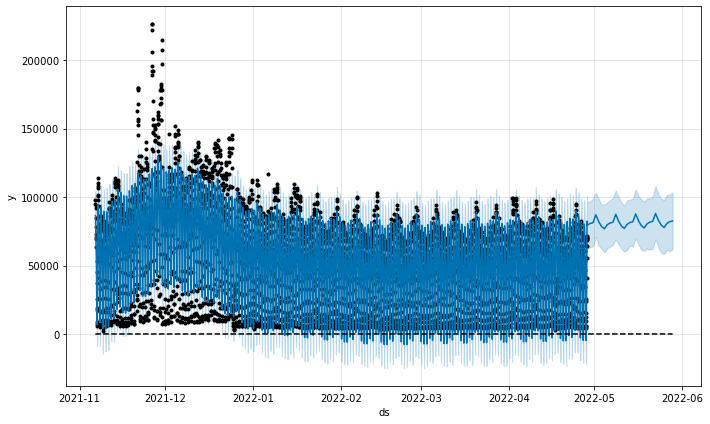

In [111]:
fig1 = m.plot(forecast)

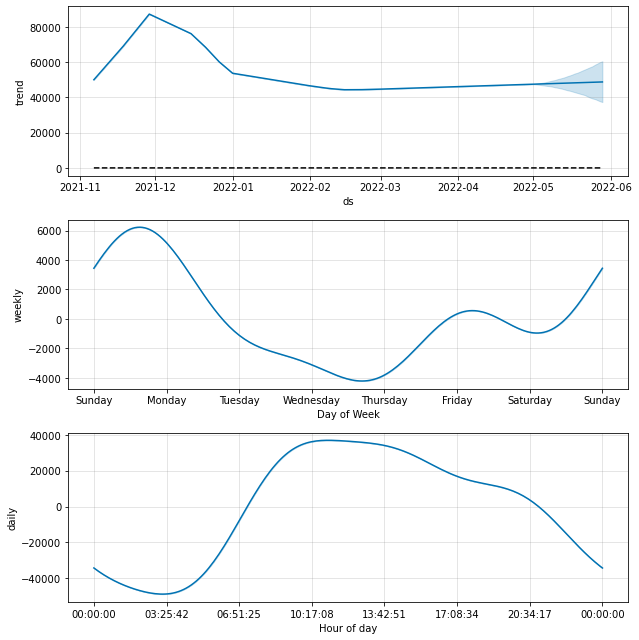

In [112]:
fig2 = m.plot_components(forecast)

In [113]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [121]:

postgres_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
postgres_df.to_sql('oph_forecast', cnx, if_exists='replace', index=False)